## pr3_utils

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler

def load_data(file_name):
    '''
    function to read visual features, IMU measurements, and calibration parameters
    Input:
        file_name: the input data file. Should look like "XX.npz"
    Output:
        t: time stamp
            with shape 1*t
        features: visual feature point coordinates in stereo images, 
            with shape 4*n*t, where n is number of features
        linear_velocity: velocity measurements in IMU frame
            with shape 3*t
        angular_velocity: angular velocity measurements in IMU frame
            with shape 3*t
        K: (left)camera intrinsic matrix
            with shape 3*3
        b: stereo camera baseline
            with shape 1
        imu_T_cam: extrinsic transformation from (left) camera to imu frame, in SE(3).
            with shape 4*4
    '''
    with np.load(file_name) as data:
    
        t = data["time_stamps"] # time_stamps
        features = data["features"] # 4 x num_features : pixel coordinates of the visual features
        linear_velocity = data["linear_velocity"] # linear velocity in body-frame coordinates
        angular_velocity = data["angular_velocity"] # angular velocity in body-frame coordinates
        K = data["K"] # intrinsic calibration matrix
        b = data["b"] # baseline
        imu_T_cam = data["imu_T_cam"] # transformation from left camera frame to imu frame 
    
    return t,features,linear_velocity,angular_velocity,K,b,imu_T_cam


def visualize_trajectory_2d(pose,path_name="Unknown",show_ori=False):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    plt.show(block=True)

    return fig, ax




def projection(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  r = n x 4 = ph/ph[...,2] = normalized z axis coordinates
  '''  
  return ph/ph[...,2,None]
  
def projectionJacobian(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  J = n x 4 x 4 = Jacobian of ph/ph[...,2]
  '''  
  J = np.zeros(ph.shape+(4,))
  iph2 = 1.0/ph[...,2]
  ph2ph2 = ph[...,2]**2
  J[...,0,0], J[...,1,1],J[...,3,3] = iph2,iph2,iph2
  J[...,0,2] = -ph[...,0]/ph2ph2
  J[...,1,2] = -ph[...,1]/ph2ph2
  J[...,3,2] = -ph[...,3]/ph2ph2
  return J


def inversePose(T):
  '''
  @Input:
    T = n x 4 x 4 = n elements of SE(3)
  @Output:
    iT = n x 4 x 4 = inverse of T
  '''
  iT = np.empty_like(T)
  iT[...,0,0], iT[...,0,1], iT[...,0,2] = T[...,0,0], T[...,1,0], T[...,2,0] 
  iT[...,1,0], iT[...,1,1], iT[...,1,2] = T[...,0,1], T[...,1,1], T[...,2,1] 
  iT[...,2,0], iT[...,2,1], iT[...,2,2] = T[...,0,2], T[...,1,2], T[...,2,2]
  iT[...,:3,3] = -np.squeeze(iT[...,:3,:3] @ T[...,:3,3,None])
  iT[...,3,:] = T[...,3,:]
  return iT


def axangle2skew(a):
  '''
  converts an n x 3 axis-angle to an n x 3 x 3 skew symmetric matrix 
  '''
  S = np.empty(a.shape[:-1]+(3,3))
  S[...,0,0].fill(0)
  S[...,0,1] =-a[...,2]
  S[...,0,2] = a[...,1]
  S[...,1,0] = a[...,2]
  S[...,1,1].fill(0)
  S[...,1,2] =-a[...,0]
  S[...,2,0] =-a[...,1]
  S[...,2,1] = a[...,0]
  S[...,2,2].fill(0)
  return S

def axangle2twist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of se(3)
  '''
  T = np.zeros(x.shape[:-1]+(4,4))
  T[...,0,1] =-x[...,5]
  T[...,0,2] = x[...,4]
  T[...,0,3] = x[...,0]
  T[...,1,0] = x[...,5]
  T[...,1,2] =-x[...,3]
  T[...,1,3] = x[...,1]
  T[...,2,0] =-x[...,4]
  T[...,2,1] = x[...,3]
  T[...,2,3] = x[...,2]
  return T

def twist2axangle(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 6 axis-angle 
  '''
  return T[...,[0,1,2,2,0,1],[3,3,3,1,2,0]]

def axangle2adtwist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    A = n x 6 x 6 = n elements of ad(se(3))
  '''
  A = np.zeros(x.shape+(6,))
  A[...,0,1] =-x[...,5]
  A[...,0,2] = x[...,4]
  A[...,0,4] =-x[...,2]
  A[...,0,5] = x[...,1]
  
  A[...,1,0] = x[...,5]
  A[...,1,2] =-x[...,3]
  A[...,1,3] = x[...,2]
  A[...,1,5] =-x[...,0]
  
  A[...,2,0] =-x[...,4]
  A[...,2,1] = x[...,3]
  A[...,2,3] =-x[...,1]
  A[...,2,4] = x[...,0]
  
  A[...,3,4] =-x[...,5] 
  A[...,3,5] = x[...,4] 
  A[...,4,3] = x[...,5]
  A[...,4,5] =-x[...,3]   
  A[...,5,3] =-x[...,4]
  A[...,5,4] = x[...,3]
  return A

def twist2pose(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 4 x 4 pose (SE3) matrix 
  '''
  rotang = np.sqrt(np.sum(T[...,[2,0,1],[1,2,0]]**2,axis=-1)[...,None,None]) # n x 1
  Tn = np.nan_to_num(T / rotang)
  Tn2 = Tn@Tn
  Tn3 = Tn@Tn2
  eye = np.zeros_like(T)
  eye[...,[0,1,2,3],[0,1,2,3]] = 1.0
  return eye + T + (1.0 - np.cos(rotang))*Tn2 + (rotang - np.sin(rotang))*Tn3
  
def axangle2pose(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of SE(3)
  '''
  return twist2pose(axangle2twist(x))


def pose2adpose(T):
  '''
  converts an n x 4 x 4 pose (SE3) matrix to an n x 6 x 6 adjoint pose (ad(SE3)) matrix 
  '''
  calT = np.empty(T.shape[:-2]+(6,6))
  calT[...,:3,:3] = T[...,:3,:3]
  calT[...,:3,3:] = axangle2skew(T[...,:3,3]) @ T[...,:3,:3]
  calT[...,3:,:3] = np.zeros(T.shape[:-2]+(3,3))
  calT[...,3:,3:] = T[...,:3,:3]
  return calT

In [72]:
import numpy as np
dataset = "10"
filename = "../data/" + dataset + ".npz"
time_stamps,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)

In [73]:
freq = 20
features = features[:, ::freq, :]
_, M, imu_samples = features.shape
print(features.shape)

(4, 665, 3026)


# Part 1

In [74]:
pose_array_localization = np.zeros((4, 4, imu_samples))
pose_array_localization[:,:, 0] = np.identity(4) 
for t in range(1, imu_samples):
    tau_t = time_stamps[0,t] - time_stamps[0,t-1]
    axangle_sample = np.zeros((1,6))
    axangle_sample[0,:3] = linear_velocity[:,t]
    axangle_sample[0,3:] = angular_velocity[:,t]
    axangle_sample = tau_t * axangle_sample
    pose_sample = axangle2pose(axangle_sample)
    pose_array_localization[:, :, t] = pose_array_localization[:, :, t-1] @ pose_sample

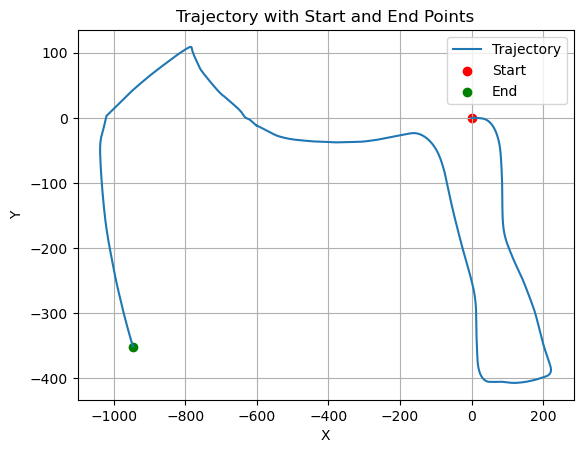

In [75]:
plt.plot(pose_array_localization[0,-1, :], pose_array_localization[1,-1, :], label='Trajectory')
plt.scatter(pose_array_localization[0,-1,0], pose_array_localization[1,-1,0], color='r', label='Start')
plt.scatter(pose_array_localization[0,-1,-1], pose_array_localization[1,-1,-1], color='g', label='End')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory with Start and End Points')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Trajectory_Initial.png')
plt.show()

# Part 2

In [76]:
def Bearing_Measurement_Triangulation_to_World(feature, pose):
    z1 = np.array([feature[0], feature[1], 1]).reshape((-1,1))
    z2 = np.array([feature[2], feature[3], 1]).reshape((-1,1))
    z1 = np.linalg.inv(K) @ z1
    z2 = np.linalg.inv(K) @ z2
    R = np.identity(3)
    p = np.array([b, 0, 0]).reshape((-1,1))
    e3 = np.array([0, 0, 1]).reshape((-1,1))
    aa = R.T @ p - (e3.T @ R.T @ p) * z2
    bb = R.T @ z1 - (e3.T @ R.T @ z1) * z2
    lambda_1 = (aa.T @ aa) / (aa.T @ bb)
    m = lambda_1 * z1
    m_homo = np.array([m[0], m[1], m[2], [1]]).reshape((-1,1))
    m_world = (pose @ imu_T_cam @ m_homo)[:3]
    return m_world

In [77]:
fisrt_observed_array = np.zeros(M)
for i in range(M):
    fisrt_observed_array[i] = int(np.where(np.any(features[:,i,:] != -1, axis=0))[0][0])
fisrt_observed_array = np.int32(fisrt_observed_array)

In [78]:
Landmark_initial = np.zeros((features.shape[1],3))
for i in range(features.shape[1]):
    time_index = fisrt_observed_array[i]
    Landmark_initial[i,:] = Bearing_Measurement_Triangulation_to_World(features[:,i,time_index], pose_array_localization[:,:,time_index]).reshape(-1)

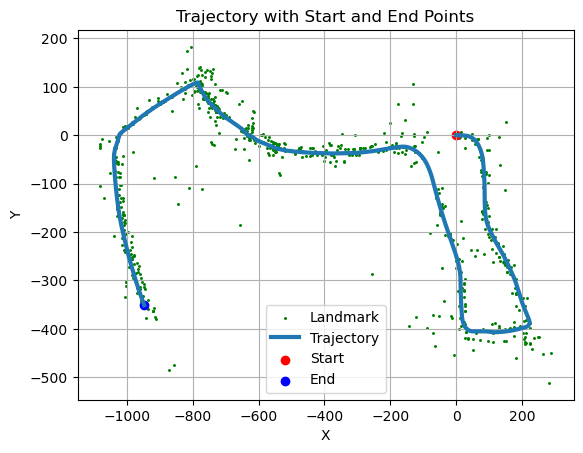

In [79]:
plt.scatter(Landmark_initial[:,0], Landmark_initial[:,1], marker='.',color='g', s=5, label="Landmark")
plt.plot(pose_array_localization[0,-1, :], pose_array_localization[1,-1, :], label='Trajectory', linewidth=3)
plt.scatter(pose_array_localization[0,-1,0], pose_array_localization[1,-1,0], color='r', label='Start')
plt.scatter(pose_array_localization[0,-1,-1], pose_array_localization[1,-1,-1], color='b', label='End')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory with Start and End Points')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Landmark_Initial.png')
plt.show()

In [80]:
P = np.zeros((3,4))
P[:,:3] = np.eye(3)
Ks = np.zeros((4,4))
Ks[:2, :3] = K[:2, :3]
Ks[2:4, :3] = K[:2, :3]
Ks[2, -1] = - K[0,0]*b

In [81]:
def calculate_h(m, pose):
    m_homo = np.array([m[0],m[1], m[2], 1]).reshape((-1,1))
    m_cam = np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose) @ m_homo
    projection_jacob = projectionJacobian(m_cam.T)[0]
    h = Ks @ projection_jacob @ np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose) @ P.T
    return h
    
def calculate_H(landmark_arr, pose, observed_features, N_t, M):
    H = np.zeros((4*N_t, 3*M))
    for counter in range(N_t):
        m = landmark_arr[observed_features[counter], :]
        h = calculate_h(m, pose)
        H[4*counter: 4*counter+4, 3*observed_features[counter]: 3*observed_features[counter]+3] = h
    return H

In [82]:
# Sigma_array = 2 * np.eye(3*M)
# mu_array = Landmark_initial.reshape(3*M)
# Landmark_array = mu_array.reshape((-1,3))

Sigma_Landmark_array = 2 * np.eye(3*M)
Landmark_EKF_array = Landmark_initial.reshape(3*M)
Landmark_EKF_array_reshaped = Landmark_EKF_array.reshape((-1,3))

In [83]:
for t in range(imu_samples):
    #print(t)
    Landmark_EKF_array_reshaped = Landmark_EKF_array.reshape((-1,3))
    observed_features = np.where(np.any(features[:,:,t] != -1, axis=0))[0]
    N_t = len(observed_features)
    if N_t==0:
        continue
    V_t = 4 * np.eye(4 * N_t)
    pose_t = pose_array_localization[:,:,t]
    H_t = calculate_H(Landmark_EKF_array_reshaped, pose_t, observed_features, N_t, M)
    K_t = Sigma_Landmark_array @ H_t.T @ np.linalg.inv(H_t @ Sigma_Landmark_array @ H_t.T + V_t)
    z_t = features[:, observed_features, t].T.reshape(-1,1)
    seen_mu_array = Landmark_EKF_array_reshaped[observed_features,:].T
    seen_mu_array_homo = np.concatenate((seen_mu_array, np.ones((1, seen_mu_array.shape[1]))), axis=0)
    seen_mu_camera = np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose_t) @ seen_mu_array_homo
    z_bar = (Ks @ projection(seen_mu_camera.T).T).T.reshape(-1,1)
    Landmark_EKF_array = Landmark_EKF_array + np.squeeze(K_t @ (z_t - z_bar))
    Sigma_Landmark_array = (np.eye(3*M) - K_t @ H_t) @ Sigma_Landmark_array

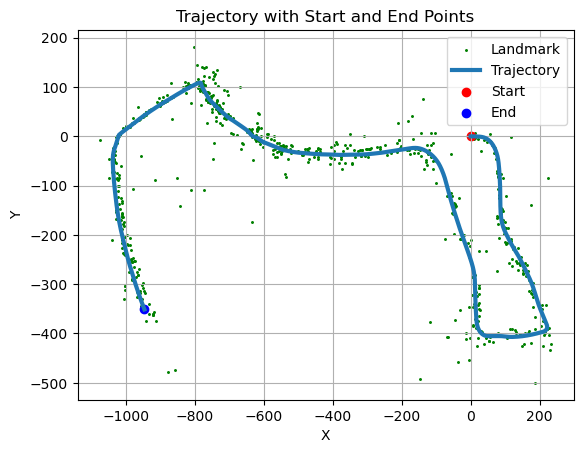

In [84]:
Landmark_EKF_array_reshaped = Landmark_EKF_array.reshape((-1,3))
plt.scatter(Landmark_EKF_array_reshaped[:,0], Landmark_EKF_array_reshaped[:,1], marker='.',color='g', s=5, label="Landmark")
plt.plot(pose_array_localization[0,-1, :], pose_array_localization[1,-1, :], label='Trajectory', linewidth=3)
plt.scatter(pose_array_localization[0,-1,0], pose_array_localization[1,-1,0], color='r', label='Start')
plt.scatter(pose_array_localization[0,-1,-1], pose_array_localization[1,-1,-1], color='b', label='End')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory with Start and End Points')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Landmark_EKF.png')
plt.show()

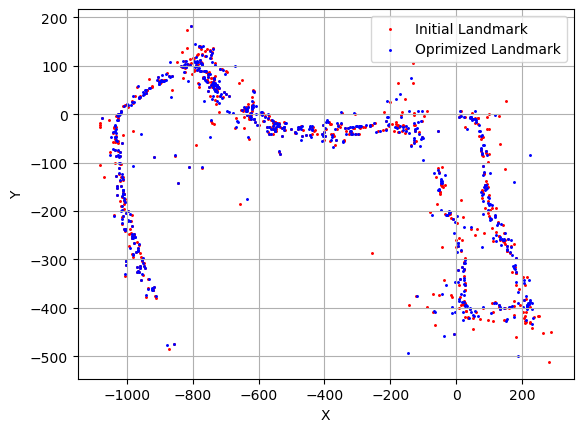

In [85]:
plt.scatter(Landmark_initial[:,0], Landmark_initial[:,1], marker='.',color='r', s=5, label="Initial Landmark")
plt.scatter(Landmark_EKF_array_reshaped[:,0], Landmark_EKF_array_reshaped[:,1], marker='.',color='b', s=5, label="Oprimized Landmark")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Landmark_EKF_vs_Initial.png')
plt.show()

# Part 3: Visual-inertial SLAM

In [86]:
def calculate_h_p(m, pose_t):
    m_homo = np.array([m[0],m[1], m[2], 1]).reshape((-1,1))
    m_imu = np.linalg.inv(pose_t) @ m_homo
    m_cam = np.linalg.inv(imu_T_cam) @ m_imu
    projection_jacob = projectionJacobian(m_cam.T)[0]
    m_imu_hat = np.zeros((4,6))
    m_imu_hat[:3,:3] = np.eye(3)
    m_imu_hat[:3,3:] = - axangle2skew(m_imu[:3].T)[0]
    h_p = -Ks @ projection_jacob @ np.linalg.inv(imu_T_cam) @ m_imu_hat
    return h_p
    
def calculate_H_p(landmark_arr, pose_t, observed_features, N_t, M):
    H_p = np.zeros((4*N_t, 6))
    for counter in range(N_t):
        m = landmark_arr[observed_features[counter], :]
        h_p = calculate_h_p(m, pose_t)
        H_p[4*counter: 4*counter+4, :] = h_p
    return H_p
    
# print(calculate_h_p(Landmark_array_t[0,:], pose))
# print(calculate_h_p(Landmark_array_t[1,:], pose))
# print(calculate_H_p(Landmark_array_t, pose, observed_features, N_t, M))

In [87]:
Landmark_initial.shape, Landmark_EKF_array.shape

((665, 3), (1995,))

In [88]:
from scipy.linalg import expm
#W = np.diag([1e-1, 1e-2, 1e-2, 1e-5, 1e-5, 1e-4])
W = np.diag([1e-2, 1e-2, 1e-2, 1e-5, 1e-5, 1e-5]) # * 1e-2

# initialization
Pose_SLAM_array = np.zeros((4, 4, imu_samples))
Pose_SLAM_array[:, :, 0] = np.identity(4)

Landmark_SLAM_array = Landmark_initial.reshape(3*M) #Landmark_EKF_array
Sigma_SLAM_array = np.zeros((3*M+6, 3*M+6))
Sigma_SLAM_array[0:3*M, 0:3*M] = 2 * np.eye(3*M) # 2 - mahdi 5
Sigma_SLAM_array[3*M:, 3*M:] = np.diag([1e-2,1e-2,1e-2,1e-2,1e-2,1e-2]) # mahdi np.diag([1e-2,1e-2,1e-2,1e-2,1e-2,1e-2]) # np.diag([1e-3,1e-3,1e-3,1e-4,1e-4,1e-4])

for t in range(1, imu_samples): #imu_samples):
    #print(t)
    axangle_sample = np.zeros((1,6))
    axangle_sample[0, :3] = linear_velocity[:,t]
    axangle_sample[0, 3:] = angular_velocity[:,t]
    tau_t = time_stamps[0,t] - time_stamps[0,t-1]
    axangle_sample = tau_t * axangle_sample
    pose_sample = axangle2pose(axangle_sample)[0]
    mu_t_t = Pose_SLAM_array[:, :, t-1] @ pose_sample

    F_t = expm(-axangle2adtwist(axangle_sample)[0])
    Sigma_SLAM_array[3*M:, 3*M:] = F_t @ Sigma_SLAM_array[3*M:, 3*M:] @ F_t.T + W
    Sigma_SLAM_array[3*M:, :3*M] = F_t @ Sigma_SLAM_array[3*M:, :3*M]
    Sigma_SLAM_array[:3*M, 3*M:] = Sigma_SLAM_array[:3*M, 3*M:] @ F_t.T

    Landmark_SLAM_array_reshaped = Landmark_SLAM_array.reshape((-1,3))
    observed_features = np.where(np.any(features[:,:,t] != -1, axis=0))[0]
    N_t = len(observed_features)
    if N_t==0:
        #print(t)
        Pose_SLAM_array[:,:, t] = mu_t_t
        continue
    V_t = 4 * np.eye(4*N_t) # 15
    pose_t = mu_t_t
    H_l = calculate_H(Landmark_SLAM_array_reshaped, pose_t, observed_features, N_t, M)
    H_p = calculate_H_p(Landmark_SLAM_array_reshaped, pose_t, observed_features, N_t, M)
    H_t = np.concatenate((H_l, H_p), axis=1)
    K_t = Sigma_SLAM_array @ H_t.T @ np.linalg.pinv(H_t @ Sigma_SLAM_array @ H_t.T + V_t)
    z_t = features[:, observed_features, t].T.reshape(-1,1)
    seen_mu_array = Landmark_SLAM_array_reshaped[observed_features,:].T
    seen_mu_array_homo = np.concatenate((seen_mu_array, np.ones((1, seen_mu_array.shape[1]))), axis=0)
    seen_mu_camera = np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose_t) @ seen_mu_array_homo
    z_bar = (Ks @ projection(seen_mu_camera.T).T).T.reshape(-1,1)
    change_t = np.squeeze(K_t @ (z_t - z_bar))
    Landmark_SLAM_array = Landmark_SLAM_array + change_t[:3*M]
    Pose_SLAM_array[:,:, t] = mu_t_t @ (axangle2pose(change_t[3*M:].reshape(1,-1))[0])
    Sigma_SLAM_array = (np.eye(3*M+6) - K_t @ H_t) @ Sigma_SLAM_array

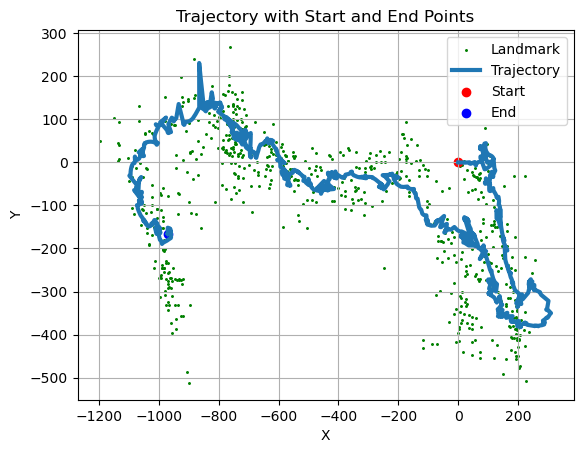

In [89]:
Landmark_SLAM_array_reshaped = Landmark_SLAM_array.reshape((-1,3))
plt.scatter(Landmark_SLAM_array_reshaped[:,0], Landmark_SLAM_array_reshaped[:,1], marker='.',color='g', s=5, label="Landmark")
plt.plot(Pose_SLAM_array[0,-1, :], Pose_SLAM_array[1,-1, :], label='Trajectory', linewidth=3)
plt.scatter(Pose_SLAM_array[0,-1,0], Pose_SLAM_array[1,-1,0], color='r', label='Start')
plt.scatter(Pose_SLAM_array[0,-1,-1], Pose_SLAM_array[1,-1,-1], color='b', label='End')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory with Start and End Points')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Landmark_SLAM.png')
plt.show()

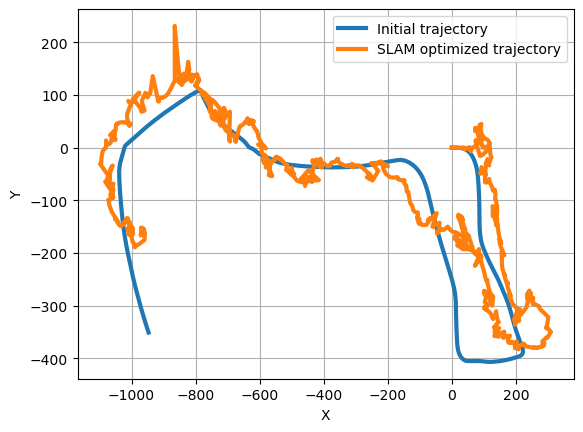

In [90]:
plt.plot(pose_array_localization[0,-1, :], pose_array_localization[1,-1, :], label='Initial trajectory', linewidth=3)
plt.plot(Pose_SLAM_array[0,-1, :], Pose_SLAM_array[1,-1, :], label='SLAM optimized trajectory', linewidth=3)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Trajectory_SLAM_vs_Initial.png')
plt.show()

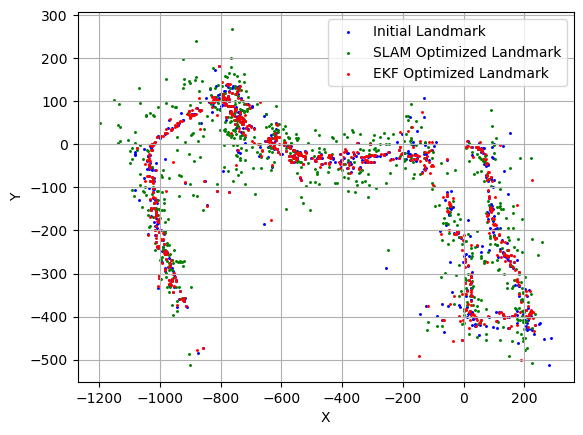

In [91]:
plt.scatter(Landmark_initial[:,0], Landmark_initial[:,1], marker='.',color='b', s=5, label="Initial Landmark")
plt.scatter(Landmark_SLAM_array_reshaped[:,0], Landmark_SLAM_array_reshaped[:,1], marker='.',color='g', s=5, label="SLAM Optimized Landmark")
plt.scatter(Landmark_EKF_array_reshaped[:,0], Landmark_EKF_array_reshaped[:,1], marker='.',color='r', s=5, label="EKF Optimized Landmark")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.savefig(f'./Result/{dataset}_Landmark_SLAM_vs_EKF_vs_Initial.png')
plt.show()